* 참조 깃헙
    * 모델 하나로 만들자.
* Base code
    * https://github.com/GunhoChoi/PyTorch-FastCampus/blob/master/07_Transfer_Learning/0_Pretrained_Basic/Transfer_Learning.ipyn
        * 모델 하나로 만들자.
    * 01_pretrainedVGG_media_v4
    * MediaClassifier_a_VGG
* MediaClassifier_d_Densenet

## 1. Settings
### 1) Important required libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt

### 2) Hyperparameter

In [2]:
batch_size= 8  #1
learning_rate = 0.0001
epoch = 50

n_node = 32  # customized last layer 의 노드 수. 64, 128, 256, 512, 1024
dropratio = 0.3   # 얼마나 드랍시킬지 inverse keepratio 

## 2. Data Loader

### 고정된 데이터 셋

In [3]:
imgsize = 256

# 1. Train data
img_dir = "../../images/painting_dataset/real_artwork_divided_shffl_4K/Train"
#img_dir = "../images/car_dataset2/car_training"
train_data = dset.ImageFolder(img_dir, transforms.Compose([
            #transforms.Scale(256),
            #transforms.RandomSizedCrop(224),
    
            transforms.CenterCrop(size=imgsize),
            transforms.Scale(imgsize),
            transforms.ToTensor()
            ]))
train_batch = data.DataLoader(train_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)

# 2. Dev data
img_dir = "../../images/painting_dataset/real_artwork_divided_shffl_4K/Valid"
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
            #transforms.Scale(256),
            #transforms.RandomSizedCrop(224),
    
            transforms.CenterCrop(size=imgsize),
            transforms.Scale(imgsize),
            transforms.ToTensor()
            ]))
dev_batch = data.DataLoader(dev_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)


# 3. Test data
img_dir = "../../images/painting_dataset/real_artwork_divided_shffl_4K/Test"
test_data = dset.ImageFolder(img_dir, transforms.Compose([
            #transforms.Scale(256),
            #transforms.RandomSizedCrop(224),
    
            transforms.CenterCrop(size=imgsize),
            transforms.Scale(imgsize),
            transforms.ToTensor()
            ]))
test_batch = data.DataLoader(test_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)
        
nclass = len(train_data.classes)
print("# of classes: %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d" %(train_data.__len__(), dev_data.__len__(), test_data.__len__()))

# for imgs, labels in train_batch:
#     for j in range(len(imgs)):
#         img = transforms.ToPILImage()(imgs[j])
#         plt.title("label: %d" % labels[j])
#         plt.imshow(img)
#         plt.show()

# of classes: 4
['oil', 'pastel', 'pencil', 'water']
{'water': 3, 'pastel': 1, 'oil': 0, 'pencil': 2}
2895
Training: 2895, Dev: 620, Test: 621


## 3. Model
### 1) Pretrained Densenet Model

In [4]:
densenet = models.densenet161(pretrained=True)

for name,module in densenet.named_children():
    print(name)

# print(list(vgg.children())[0])
# print(list(vgg.children())[-1])

# print("\n")

#cnt = 0
for i in densenet.children():
    #print("yhk[%d]" %cnt),
    print(i)
    #cnt = cnt+1

features
classifier
Sequential (
  (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
  (relu0): ReLU (inplace)
  (pool0): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (denseblock1): _DenseBlock (
    (denselayer1): _DenseLayer (
      (norm.1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
      (relu.1): ReLU (inplace)
      (conv.1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm.2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True)
      (relu.2): ReLU (inplace)
      (conv.2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer (
      (norm.1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True)
      (relu.1): ReLU (inplace)
      (conv.1): Conv2d(144, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm.2): BatchNorm2d(192, eps=1e-05,

### 2) Customized Fully Model

In [5]:
class MyDensenet(nn.Module):
    def __init__(self):
        super(MyDensenet, self).__init__()
        self.layer0 = nn.Sequential(*list(densenet.children())[0])  # [0]: features(conv), [1]: classifier(fc)
        self.layer1 = nn.Sequential(
            #nn.Linear(8*base_dim * fsize * fsize, 1024),
            nn.Linear(2208*8*8, n_node),   # 256*6*6: out = self.layer0(x) 의 out 을 프린트하는 무식한 방법으로 알아냄.
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),  # 0.3 만큼 drop 하자.
            
#             nn.Linear(n_node, n_node),
#             nn.BatchNorm1d(n_node),
#             nn.ReLU(),
#             nn.Dropout2d(dropratio),
            
#             nn.Linear(n_node, n_node),
#             nn.BatchNorm1d(n_node),
#             nn.ReLU(),
#             nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, nclass),
        )
        # weight initialization
        for m in self.layer1.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)  # REUL 일 때
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
    def forward(self, x):
        out = self.layer0(x)
        #print(out)
        out = out.view(out.size(0), -1)
        out = self.layer1(out)
        return out

### 3) Model on GPU

In [6]:
model = MyDensenet().cuda()

for params in model.layer0.parameters():
    params.required_grad = False
    
for params in model.layer1.parameters():
    params.required_grad = True

In [7]:
for name in model.children():
    print(name)

Sequential (
  (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU (inplace)
  (3): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (4): _DenseBlock (
    (denselayer1): _DenseLayer (
      (norm.1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
      (relu.1): ReLU (inplace)
      (conv.1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm.2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True)
      (relu.2): ReLU (inplace)
      (conv.2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer (
      (norm.1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True)
      (relu.1): ReLU (inplace)
      (conv.1): Conv2d(144, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm.2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True)
      (relu.2): Re

## 4. Optimizer & Loss

In [8]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(),lr=learning_rate)

## 5. Train

In [9]:
import utils

total_time = 0
disp_step = 10
netname = './nets/media_dense.pkl'

to_train = True
if (to_train==False):
    model = torch.load(netname)
else:
    # graph 그리기
    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []
    
    model.eval()  # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
    train_corr = utils.ComputeCorr(train_batch, model)
    dev_corr = utils.ComputeCorr(dev_batch, model)
    test_corr = utils.ComputeCorr(test_batch, model)
    print("1 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
    print("Correct of train: %.2f, dev: %.2f, test: %.2f" 
          %(train_corr, dev_corr, test_corr))
    model.train()
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
#     # 학습을 재시작한다면
#     netname = '../nets/media_pre_vgg19.pkl'
#     model = torch.load(netname)
#     # 파라미터 학습 여부 결정
#     for params in model.layer0.parameters():
#         params.required_grad = False    
#     for params in model.layer1.parameters():
#         params.required_grad = True
#     for i in range(34, epoch):
    
    # 재시작하지 않는 다면
    for i in range(epoch):
        start_time = time.time()
        print("%d.." %i),
        for img,label in train_batch:
            img = Variable(img).cuda()
            label = Variable(label).cuda()

            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output,label)
            loss.backward()
            optimizer.step()

        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        if (i % disp_step == 0) or (i==epoch-1):
            torch.save(model, netname, )
            print("\n[%d/%d] loss: %.3f, " %(i, epoch, (loss.cpu()).data.numpy())),
            
            # train, dev, train accr
            model.eval()  # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
            train_corr = utils.ComputeCorr(train_batch, model)
            dev_corr = utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(test_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f" 
                  %(train_corr, dev_corr, test_corr)),
            model.train()            
            print("time: %.2f sec.." %(total_time))
            
            # graph 그리기
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
    print("Total time: %.2f sec" %total_time)

1 layer, n_node: 32, dropratio: 0.30
Correct of train: 25.46, dev: 26.61, test: 24.15
0..

/home/cgvmu/anaconda2/envs/pytorch/lib/python2.7/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type MyDensenet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


 
[0/50] loss: 0.695,  Correct of train: 88.88, dev: 79.19, test: 76.81 time: 59.62 sec..
1.. 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 
[10/50] loss: 0.359,  Correct of train: 99.90, dev: 80.00, test: 80.03 time: 657.23 sec..
11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 
[20/50] loss: 0.144,  Correct of train: 100.00, dev: 81.29, test: 81.16 time: 1253.53 sec..
21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 
[30/50] loss: 0.166,  Correct of train: 100.00, dev: 80.48, test: 80.35 time: 1850.41 sec..
31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 
[40/50] loss: 0.645,  Correct of train: 99.97, dev: 79.52, test: 79.55 time: 2438.05 sec..
41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 
[49/50] loss: 0.015,  Correct of train: 99.97, dev: 80.16, test: 80.35 time: 2959.85 sec..
Total time: 2959.85 sec


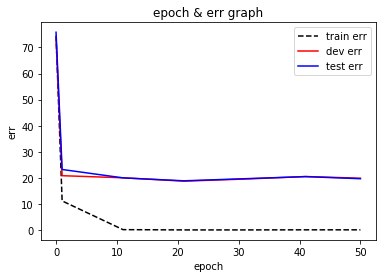

In [10]:
# epoch-err curve 
if (to_train):
    plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
    plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label='test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc="upper right")
    plt.show()

## 6. Evaluation for dev & test data

Normalized confusion matrix


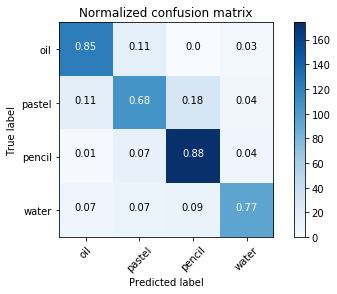

Confusion matrix, without normalization


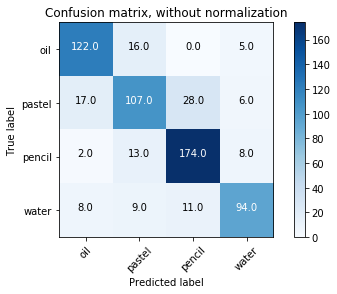

	 acc  |	 pre  |	 rec  |	 f1
 oil: 0.92 |	 0.82 |	 0.85 |	 0.84
 pastel: 0.83 |	 0.74 |	 0.68 |	 0.71
 pencil: 0.85 |	 0.82 |	 0.88 |	 0.85
 water: 0.92 |	 0.83 |	 0.77 |	 0.80
*accuracy: 0.88, precision: 0.80, recall: 0.80, *f1 score: 0.80


In [11]:
model.eval()   # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


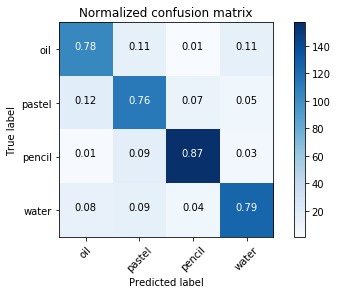

Confusion matrix, without normalization


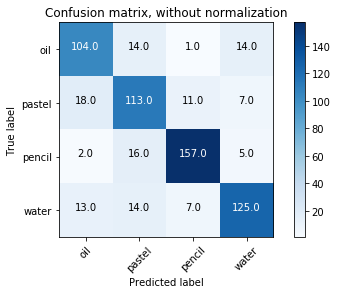

	 acc  |	 pre  |	 rec  |	 f1
 oil: 0.90 |	 0.76 |	 0.78 |	 0.77
 pastel: 0.82 |	 0.72 |	 0.76 |	 0.74
 pencil: 0.86 |	 0.89 |	 0.87 |	 0.88
 water: 0.90 |	 0.83 |	 0.79 |	 0.81
*accuracy: 0.87, precision: 0.80, recall: 0.80, *f1 score: 0.80


In [12]:
utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)